# Analisis Interaksi Siswa Berdasarkan Topik Soal dengan LDA
Notebook ini menyajikan tahapan analisis dari pengumpulan data hingga rekomendasi pembelajaran adaptif berdasarkan pemodelan topik LDA.
Judul "Pembentukan Profil Belajar Siswa Berbasis EdNet Menggunakan LDA dan Analisis Topik Soal"

In [ ]:
pip install gensim

In [ ]:
# 1. Mount Google Drive (jika file di Google Drive)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Pengumpulan & Penggabungan Data

In [ ]:
import pandas as pd
import zipfile
import os
from tqdm import tqdm
from google.colab import files

# Ekstrak file ZIP
zip_path = "/content/drive/MyDrive/Eksperiment/EdNet-KT1.zip"
extract_path = "KT1_extracted"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    csv_files = [f for f in zip_ref.namelist() if f.endswith('.csv')][:1000]
    zip_ref.extractall(path=extract_path, members=csv_files)

# Gabungkan data interaksi
interaksi_df_list = []

for file_name in tqdm(csv_files):
    file_path = os.path.join(extract_path, file_name)
    user_id = os.path.splitext(os.path.basename(file_name))[0]

    try:
        df = pd.read_csv(file_path, sep=',')  # <- GANTI ke koma
        df['user_id'] = user_id
        interaksi_df_list.append(df)
    except Exception as e:
        print(f"Error reading {file_name}: {e}")

interaksi_df = pd.concat(interaksi_df_list, ignore_index=True)

# Baca questions.csv juga dengan delimiter koma
questions_df = pd.read_csv("/content/drive/MyDrive/Eksperiment/questions.csv", sep=',')

# Cek kolom untuk memastikan
print("Kolom interaksi_df:", interaksi_df.columns.tolist())
print("Kolom questions_df:", questions_df.columns.tolist())

# Gabungkan berdasarkan question_id
gabungan_df = pd.merge(interaksi_df, questions_df, on='question_id', how='left')

# Simpan ke file akhir
output_filename = "interaksi_soal_gabungan.csv"
gabungan_df.to_csv(output_filename, index=False)
# files.download(output_filename)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Eksperiment/EdNet-KT1.zip'

In [ ]:
# Buka file hasil gabungan
df = pd.read_csv("interaksi_soal_gabungan.csv")

# Tampilkan 5 baris pertama
df.head()

,timestamp,solving_id,question_id,user_answer,elapsed_time,user_id,bundle_id,explanation_id,correct_answer,part,tags,deployed_at
0,1535196434651,1,q8098,b,20000,u246317,b5569,e5569,b,1,5;2;182,1514559983093
1,1535196459648,2,q8074,c,22000,u246317,b5545,e5545,c,1,11;7;183,1526633822552
2,1535196482553,3,q176,b,21000,u246317,b176,e176,d,1,6;7;183,1514559223800
3,1564677167247,4,q1279,c,17000,u246317,b1279,e1279,c,2,24;26;182;184,1571281118714
4,1564677196590,5,q6363,d,27000,u246317,b4895,e4895,d,5,130,1558093425874


## Preprocessing (membentuk tag dari tags yang ada pada kolom)


In [ ]:
import nltk
from nltk.corpus import stopwords
import re

# Unduh stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian') + stopwords.words('english'))

# Baca ulang data
df = pd.read_csv("interaksi_soal_gabungan.csv")

# Ambil data soal unik
soal_df = df[['question_id', 'tags']].drop_duplicates(subset='question_id')

# Perbaiki fungsi tag-to-text
def tags_to_text(tag_str):
    if pd.isna(tag_str):
        return ''
    # Pisahkan berdasarkan koma, spasi, atau titik koma
    tag_list = re.split(r'[,\s;]+', str(tag_str).strip())
    words = [f"tag_{tag}" for tag in tag_list if tag]
    return ' '.join(words)

# Bersihkan dan ubah ke pseudo-text
soal_df['pseudo_text'] = soal_df['tags'].apply(tags_to_text)

# Bersihkan stopwords (walau jarang masuk karena pseudo)
def clean_text(text):
    tokens = text.split()
    tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(tokens)

soal_df['pseudo_text'] = soal_df['tags'].apply(tags_to_text)
soal_df['clean_text'] = soal_df['pseudo_text'].apply(clean_text)

# Simpan hasil

soal_text_df = soal_df[['question_id', 'clean_text']]
soal_text_df.to_csv("soal_pseudo_text.csv", index=False)
soal_text_df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,question_id,clean_text
0,q8098,tag_5 tag_2 tag_182
1,q8074,tag_11 tag_7 tag_183
2,q176,tag_6 tag_7 tag_183
3,q1279,tag_24 tag_26 tag_182 tag_184
4,q6363,tag_130


## 2. Representasi Soal (Bag-of-Words)

In [ ]:
!pip install gensim

In [ ]:
import pandas as pd
import gensim
from gensim import corpora
from sklearn.feature_extraction.text import CountVectorizer

# Baca data soal teks
soal_text_df = pd.read_csv("soal_pseudo_text.csv")

# Langkah 1: Tokenisasi teks
soal_text_df['tokens'] = soal_text_df['clean_text'].apply(lambda x: x.split())

# Langkah 2: Buat dictionary dan corpus (gensim format)
dictionary = corpora.Dictionary(soal_text_df['tokens'])

# Filter token yang terlalu jarang/terlalu sering (opsional)
dictionary.filter_extremes(no_below=5, no_above=0.8)

# Corpus: representasi BoW
corpus = [dictionary.doc2bow(text) for text in soal_text_df['tokens']]

# Langkah 3: Validasi Jumlah Dokumen dan Sparsity
vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
X = vectorizer.fit_transform(soal_text_df['tokens'])

num_docs = X.shape[0]
sparsity = 1.0 - X.count_nonzero() / float(X.shape[0] * X.shape[1])

print(f"Jumlah dokumen: {num_docs}")
print(f"Sparsity (tingkat kekosongan): {sparsity:.2%}")
print(f"Jumlah token unik (fitur BoW): {X.shape[1]}")


Jumlah dokumen: 11613
Sparsity (tingkat kekosongan): 98.82%
Jumlah token unik (fitur BoW): 189


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## 3. LDA Topic Modeling

In [ ]:
from gensim.models import LdaModel, CoherenceModel

# --- Hyperparameter
num_topics = 20
passes = 30  # jumlah pass melalui data

# --- Training LDA
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=passes,
    alpha='auto',
    per_word_topics=True
)

# --- Tampilkan Topik
topik_output = lda_model.print_topics(num_words=10)
for i, topic in enumerate(topik_output):
    print(f"Topik {i}: {topic[1]}")

# --- Hitung Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=soal_text_df['tokens'],
                                     dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f"\n✅ Coherence Score: {coherence_score:.4f}")


Topik 0: 0.265*"tag_54" + 0.147*"tag_182" + 0.139*"tag_183" + 0.112*"tag_181" + 0.110*"tag_55" + 0.094*"tag_184" + 0.079*"tag_80" + 0.022*"tag_63" + 0.010*"tag_20" + 0.010*"tag_21"
Topik 1: 0.772*"tag_179" + 0.113*"tag_156" + 0.038*"tag_152" + 0.030*"tag_1" + 0.030*"tag_10" + 0.009*"tag_137" + 0.000*"tag_178" + 0.000*"tag_176" + 0.000*"tag_147" + 0.000*"tag_162"
Topik 2: 0.715*"tag_177" + 0.079*"tag_169" + 0.047*"tag_72" + 0.046*"tag_105" + 0.042*"tag_129" + 0.031*"tag_130" + 0.020*"tag_112" + 0.009*"tag_110" + 0.000*"tag_167" + 0.000*"tag_155"
Topik 3: 0.379*"tag_153" + 0.247*"tag_84" + 0.211*"tag_177" + 0.061*"tag_94" + 0.048*"tag_95" + 0.020*"tag_115" + 0.016*"tag_124" + 0.008*"tag_140" + 0.000*"tag_146" + 0.000*"tag_159"
Topik 4: 0.569*"tag_71" + 0.159*"tag_106" + 0.108*"tag_134" + 0.076*"tag_90" + 0.072*"tag_82" + 0.000*"tag_141" + 0.000*"tag_98" + 0.000*"tag_117" + 0.000*"tag_120" + 0.000*"tag_92"
Topik 5: 0.514*"tag_74" + 0.229*"tag_149" + 0.225*"tag_76" + 0.012*"tag_19" + 0.010

## 4. Evaluasi Model Topik

In [ ]:
!pip install pyLDAvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.9 MB/s eta 0:00:00


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

# Siapkan visualisasi
pyLDAvis.enable_notebook()  # untuk notebook interaktif (opsional)

# Buat visualisasi
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

# Tampilkan di notebook
pyLDAvis.display(vis_data)


In [ ]:
# Download Visualisasi
pyLDAvis.save_html(vis_data, 'lda_visualisasi.html')
from google.colab import files
files.download('lda_visualisasi.html')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5. Assign Topik Dominan ke Soal

In [ ]:
import numpy as np

# Step 1: Ambil topik dominan dari setiap dokumen di corpus
topik_dominan = []
for i, bow in enumerate(corpus):
    topik = lda_model.get_document_topics(bow)
    topik = sorted(topik, key=lambda x: x[1], reverse=True)
    topik_id = topik[0][0] if topik else None  # topik paling dominan
    topik_dominan.append(topik_id)

# Step 2: Tambahkan ke dataframe soal
soal_text_df['topik_dominan'] = topik_dominan

# Step 3: Simpan hasil ke CSV
soal_text_df[['question_id', 'topik_dominan']].to_csv("soal_topik.csv", index=False)
soal_text_df[['question_id', 'topik_dominan']].head()


,question_id,topik_dominan
0,q8098,12
1,q8074,14
2,q176,14
3,q1279,17
4,q6363,2


## 6. Mapping Interaksi Siswa ke Topik

In [ ]:
import pandas as pd

# Langkah 1: Load data
interaksi_df = pd.read_csv("interaksi_soal_gabungan.csv")
topik_df = pd.read_csv("soal_topik.csv")

# Langkah 2: Gabungkan interaksi dengan topik soal
gabungan_df = interaksi_df.merge(topik_df, on='question_id', how='left')

# Langkah 3: Hitung label benar/salah
# Bandingkan user_answer dengan correct_answer
gabungan_df['correct'] = (gabungan_df['user_answer'] == gabungan_df['correct_answer']).astype(int)

# Langkah 4: Buat tabel agregat: user_id × topik × jumlah_benar
pivot_df = gabungan_df.groupby(['user_id', 'topik_dominan'])['correct'].agg(['count', 'sum']).reset_index()
pivot_df.rename(columns={'count': 'jumlah_interaksi', 'sum': 'jumlah_benar'}, inplace=True)

# Hitung persentase akurasi per topik
pivot_df['akurasi'] = pivot_df['jumlah_benar'] / pivot_df['jumlah_interaksi']

# Simpan hasil akhir
pivot_df.to_csv("representasi_topik_siswa.csv", index=False)
pivot_df.head()


,user_id,topik_dominan,jumlah_interaksi,jumlah_benar,akurasi
0,u100580,0,2,1,0.5
1,u100580,1,1,1,1.0
2,u100580,2,2,1,0.5
3,u100580,3,2,1,0.5
4,u100580,4,1,0,0.0


## Visualisasi Heatmap

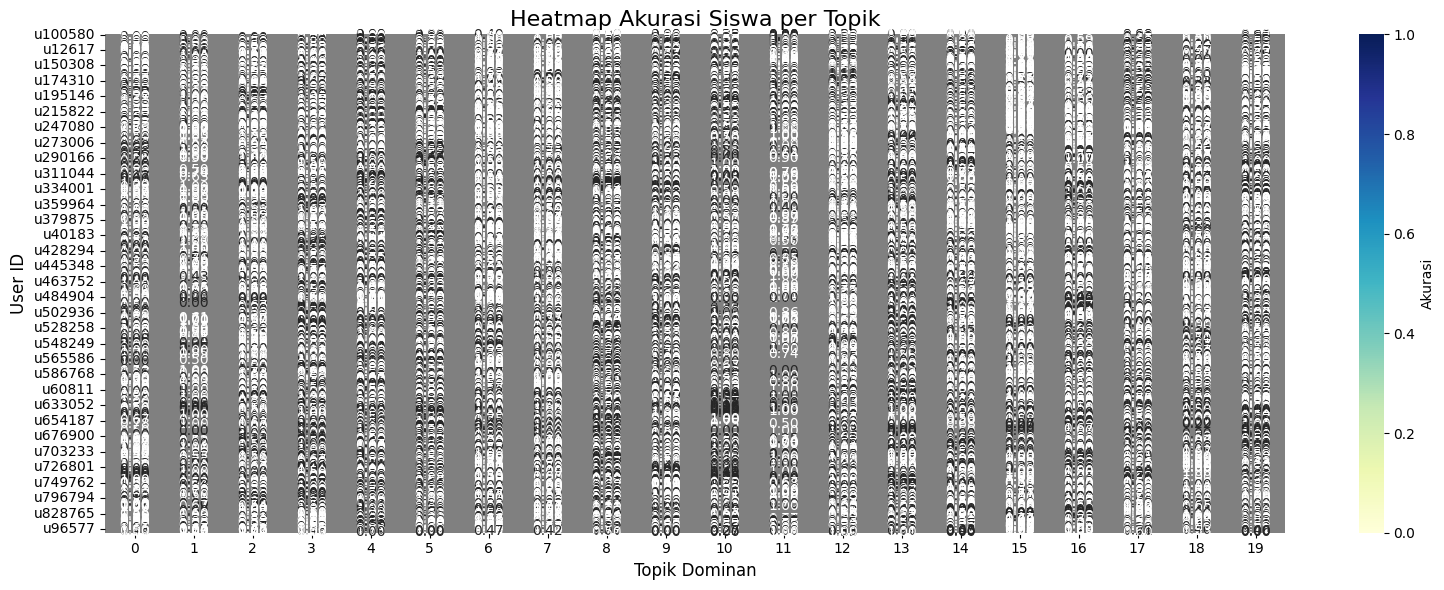

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv("representasi_topik_siswa.csv")

# Pivot ke format matriks: user_id × topik → akurasi
pivot = df.pivot(index='user_id', columns='topik_dominan', values='akurasi')

# Sort kolom (topik) agar terurut
pivot = pivot.sort_index(axis=1)

# Atur ukuran
plt.figure(figsize=(16, 6))

# Buat heatmap dengan colormap biru → merah
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Akurasi'})

# Judul dan label
plt.title("Heatmap Akurasi Siswa per Topik", fontsize=16)
plt.xlabel("Topik Dominan", fontsize=12)
plt.ylabel("User ID", fontsize=12)
plt.tight_layout()
plt.show()


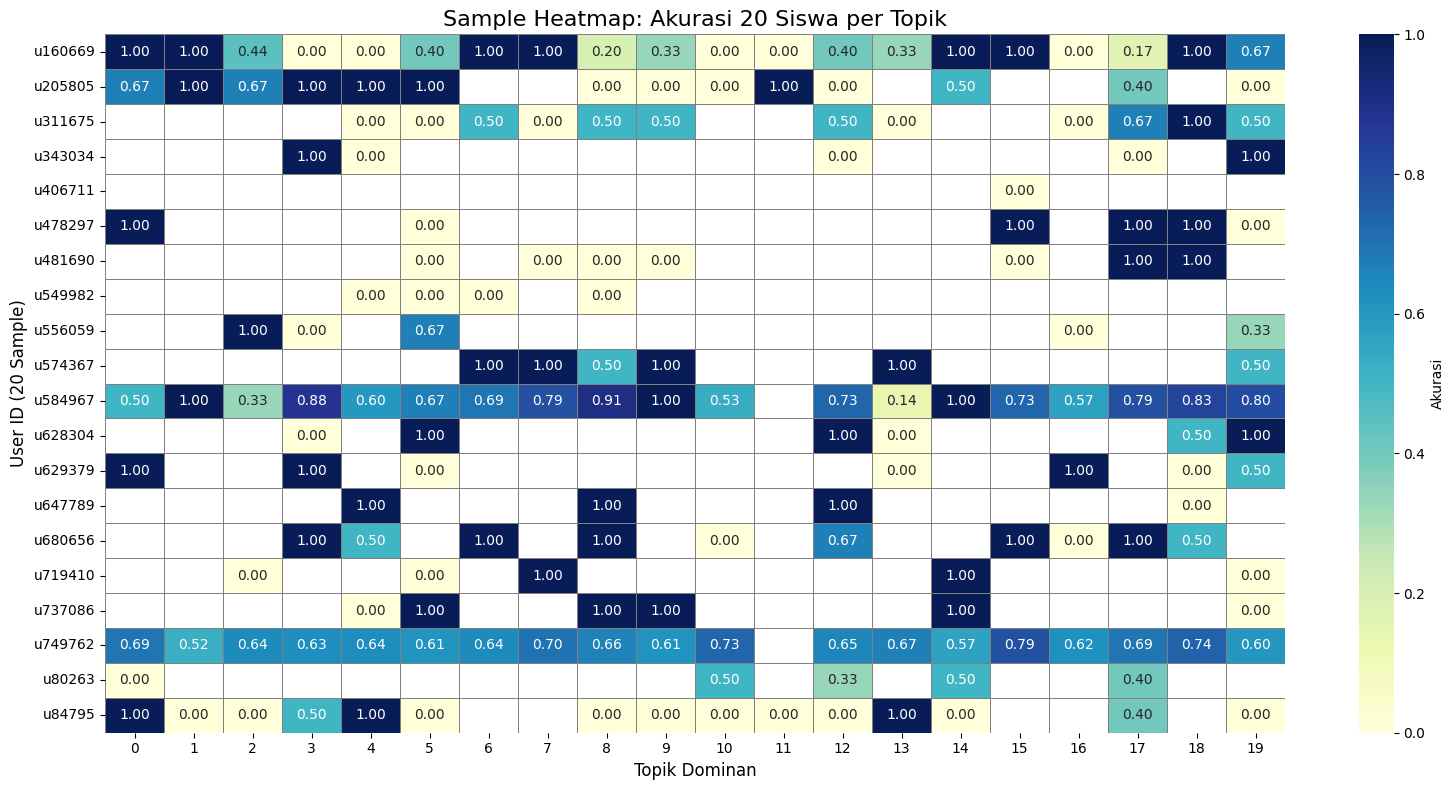

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("representasi_topik_siswa.csv")

# Pilih 20 user_id secara acak
sample_users = df['user_id'].drop_duplicates().sample(n=20, random_state=42)
df_sample = df[df['user_id'].isin(sample_users)]

# Pivot ke format matriks: user_id × topik → akurasi
pivot_sample = df_sample.pivot(index='user_id', columns='topik_dominan', values='akurasi')
pivot_sample = pivot_sample.sort_index(axis=1)  # urutkan topik

# Tampilkan heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(pivot_sample, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Akurasi'})

# Tambahkan judul dan label
plt.title("Sample Heatmap: Akurasi 20 Siswa per Topik", fontsize=16)
plt.xlabel("Topik Dominan", fontsize=12)
plt.ylabel("User ID (20 Sample)", fontsize=12)
plt.tight_layout()
plt.show()


## 7. Perhitungan Performa Siswa per Topik

In [ ]:
import pandas as pd

# Load data mapping
df = pd.read_csv("representasi_topik_siswa.csv")

# Buat pivot table: user_id × topik_dominan → akurasi
nilai_matrix = df.pivot(index='user_id', columns='topik_dominan', values='akurasi')

# Opsional: isi NaN dengan -1 (atau 0 jika dianggap "belum dikerjakan")
nilai_matrix_filled = nilai_matrix.fillna(-1)  # bisa juga .fillna(0)

# Simpan hasil matriks
nilai_matrix.to_csv("matriks_nilai_siswa_topik.csv")

# Tampilkan 5 baris contoh
nilai_matrix.head()


topik_dominan,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
user_id,,,,,,,,,,,,,,,,,,,,
u100580,0.5,1.0,0.5,0.5,0.0,0.0,0.4,NaN,0.0,0.0,0.333333,0.0,0.333333,0.0,0.0,1.0,NaN,0.000000,NaN,0.000000
u101409,0.5,1.0,1.0,0.5,0.0,1.0,NaN,NaN,0.5,0.0,0.250000,0.0,0.333333,1.0,0.5,NaN,NaN,0.400000,NaN,0.500000
u102852,0.5,0.0,1.0,1.0,1.0,0.0,NaN,NaN,0.5,1.0,0.500000,0.0,0.333333,1.0,0.0,NaN,NaN,0.600000,NaN,0.000000
u106217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.5,NaN,NaN,NaN,NaN,NaN
u106643,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.800000,0.0,0.625000,1.0,0.0,1.0,NaN,0.666667,0.5,0.666667


In [ ]:
# Hitung jumlah topik yang dikerjakan tiap siswa (bukan NaN)
jumlah_topik_terisi = nilai_matrix.notna().sum(axis=1)

# Persentase siswa dengan >5 topik
prop = (jumlah_topik_terisi > 5).mean()

print(f"✅ {prop*100:.2f}% siswa memiliki performa pada lebih dari 5 topik.")


✅ 66.00% siswa memiliki performa pada lebih dari 5 topik.


## Visualisasi distribusi Jumlah Topik

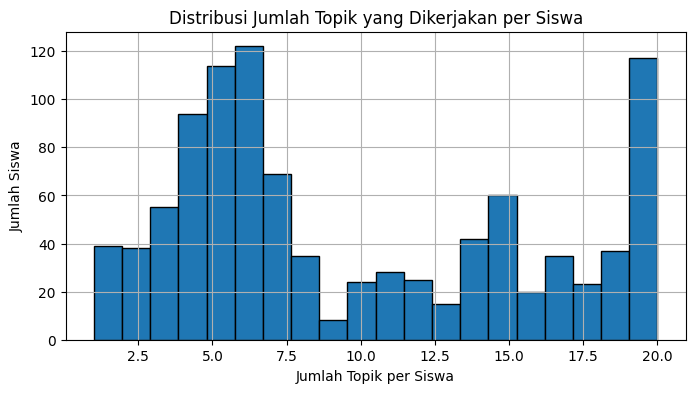

In [ ]:
import matplotlib.pyplot as plt

jumlah_topik_terisi.plot.hist(bins=20, edgecolor='black', figsize=(8,4))
plt.title("Distribusi Jumlah Topik yang Dikerjakan per Siswa")
plt.xlabel("Jumlah Topik per Siswa")
plt.ylabel("Jumlah Siswa")
plt.grid(True)
plt.show()


## 8. Bangun Matriks Siswa × Topik

In [ ]:
import pandas as pd

# Load data performa siswa per topik
df = pd.read_csv("representasi_topik_siswa.csv")

# Pivot data ke matriks: user_id × topik_dominan → akurasi
matriks = pd.pivot_table(df,
                         index='user_id',
                         columns='topik_dominan',
                         values='akurasi')

# Rename kolom agar jelas (opsional)
matriks.columns = [f"topik_{int(c)}" for c in matriks.columns]

# Simpan ke file
matriks.to_csv("matriks_user_topik.csv")

# Tampilkan ringkasan
print(f"✅ Matriks siswa-topik terbentuk dengan shape: {matriks.shape}")
print("Jumlah nilai NaN per kolom:")
print(matriks.isna().sum())

# Tampilkan 5 baris pertama
matriks.head()


✅ Matriks siswa-topik terbentuk dengan shape: (1000, 20)
Jumlah nilai NaN per kolom:
topik_0     577
topik_1     690
topik_2     540
topik_3     449
topik_4     411
topik_5     230
topik_6     607
topik_7     638
topik_8     309
topik_9     452
topik_10    604
topik_11    734
topik_12    416
topik_13    558
topik_14    487
topik_15    640
topik_16    548
topik_17    411
topik_18    633
topik_19    370
dtype: int64


,topik_0,topik_1,topik_2,topik_3,topik_4,topik_5,topik_6,topik_7,topik_8,topik_9,topik_10,topik_11,topik_12,topik_13,topik_14,topik_15,topik_16,topik_17,topik_18,topik_19
user_id,,,,,,,,,,,,,,,,,,,,
u100580,0.5,1.0,0.5,0.5,0.0,0.0,0.4,NaN,0.0,0.0,0.333333,0.0,0.333333,0.0,0.0,1.0,NaN,0.000000,NaN,0.000000
u101409,0.5,1.0,1.0,0.5,0.0,1.0,NaN,NaN,0.5,0.0,0.250000,0.0,0.333333,1.0,0.5,NaN,NaN,0.400000,NaN,0.500000
u102852,0.5,0.0,1.0,1.0,1.0,0.0,NaN,NaN,0.5,1.0,0.500000,0.0,0.333333,1.0,0.0,NaN,NaN,0.600000,NaN,0.000000
u106217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.5,NaN,NaN,NaN,NaN,NaN
u106643,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.800000,0.0,0.625000,1.0,0.0,1.0,NaN,0.666667,0.5,0.666667


## **Clustering Siswa Berdasarkan Performa Topik**

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Load matriks siswa-topik
matriks = pd.read_csv("matriks_user_topik.csv", index_col=0)

# Optional: isi NaN dengan 0 atau nilai rata-rata
X = matriks.fillna(0)

# Normalisasi (fitur: topik)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering: tentukan jumlah klaster (misal 4)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Tambahkan cluster ke DataFrame
X['cluster'] = clusters

# Simpan hasil clustering
X.to_csv("siswa_topik_cluster.csv")

# PCA untuk visualisasi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X['pca1'] = X_pca[:, 0]
X['pca2'] = X_pca[:, 1]

# Plot visualisasi cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X, x='pca1', y='pca2', hue='cluster', palette='tab10', s=60)

plt.title("Visualisasi Cluster Siswa Berdasarkan Performa Topik (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)

# Tambahkan legend manual untuk interpretasi warna
legend_labels = {
    0: ("", "Performa Menengah-Rata"),
    1: ("", "Performa Rendah / Belum Merata"),
    2: ("", "Siswa Berperforma Tinggi"),
    3: ("", "Outlier / Inkonsisten"),
}

custom_patches = [
    mpatches.Patch(color=sns.color_palette('tab10')[i], label=f"{v[0]} (Cluster {i}) – {v[1]}")
    for i, v in legend_labels.items()
]

plt.legend(handles=custom_patches, title="Keterangan Cluster", loc='best')
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'matriks_user_topik.csv'

In [ ]:
from scipy.stats import f_oneway

# Tambahkan kolom skor rata-rata per siswa
X['avg_score'] = X.drop(columns=['cluster', 'pca1', 'pca2']).mean(axis=1)

# Kelompokkan berdasarkan cluster
groups = [group['avg_score'].values for _, group in X.groupby('cluster')]

# Uji ANOVA satu arah
f_stat, p_val = f_oneway(*groups)
print(f"F-statistic: {f_stat:.4f}, p-value: {p_val:.4f}")


NameError: name 'X' is not defined

In [ ]:
# Ambil kembali data original (tanpa PCA)
data_cluster = X.drop(columns=['pca1', 'pca2'])

# Hitung rata-rata akurasi per topik per cluster
cluster_stats = data_cluster.groupby('cluster').mean()

# Tambahkan ukuran cluster
cluster_stats['jumlah_siswa'] = data_cluster['cluster'].value_counts().sort_index()

# Tampilkan ringkasan
cluster_stats.T


cluster,0,1,2,3
topik_0,0.265032,0.075397,0.637328,0.186689
topik_1,0.278659,0.012897,0.645430,0.061745
topik_2,0.390087,0.071925,0.626763,0.276815
topik_3,0.481177,0.079365,0.628567,0.262211
topik_4,0.307948,0.163029,0.604758,0.292020
topik_5,0.372006,0.245999,0.633254,0.512816
topik_6,0.270388,0.079034,0.639405,0.195875
topik_7,0.196968,0.063161,0.642458,0.154290
topik_8,0.382959,0.129200,0.595424,0.402921
topik_9,0.255739,0.142030,0.631533,0.240901


## 9. Visualisasi Profil Belajar Siswa

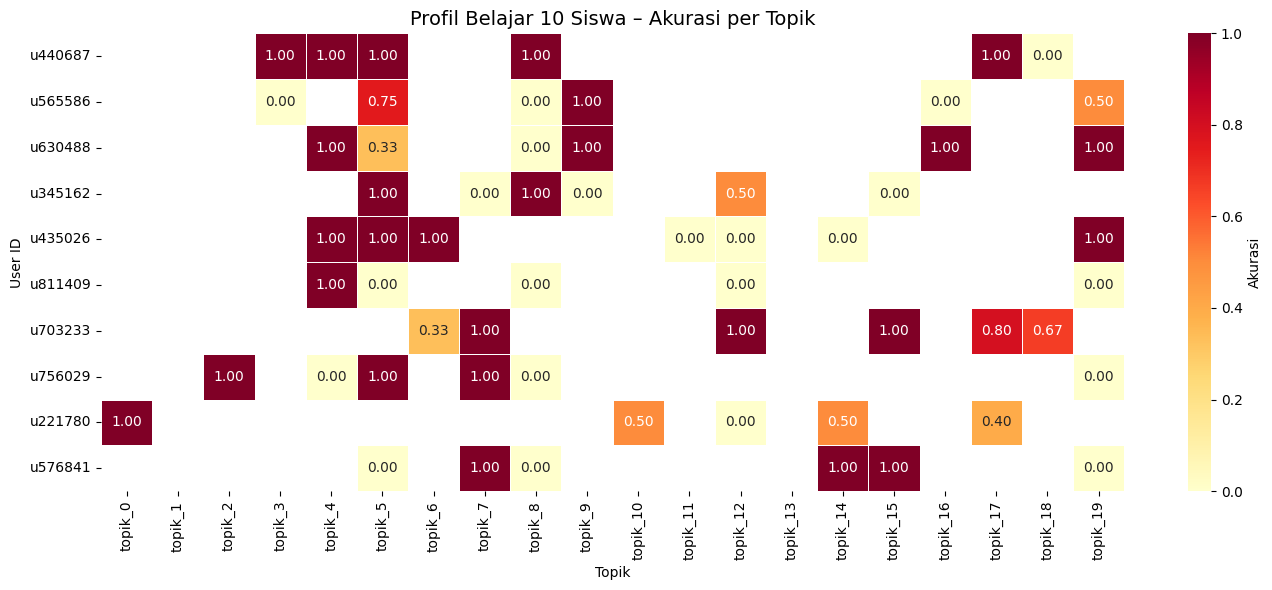

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load matriks siswa × topik
matriks = pd.read_csv("matriks_user_topik.csv", index_col=0)

# Pilih 10 siswa secara acak atau berdasarkan interaksi banyak
top10 = matriks.dropna(thresh=5).sample(10, random_state=42)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(top10, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5, cbar_kws={'label': 'Akurasi'})
plt.title("Profil Belajar 10 Siswa – Akurasi per Topik", fontsize=14)
plt.xlabel("Topik")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()


<ipython-input-21-6187b853d949>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'])


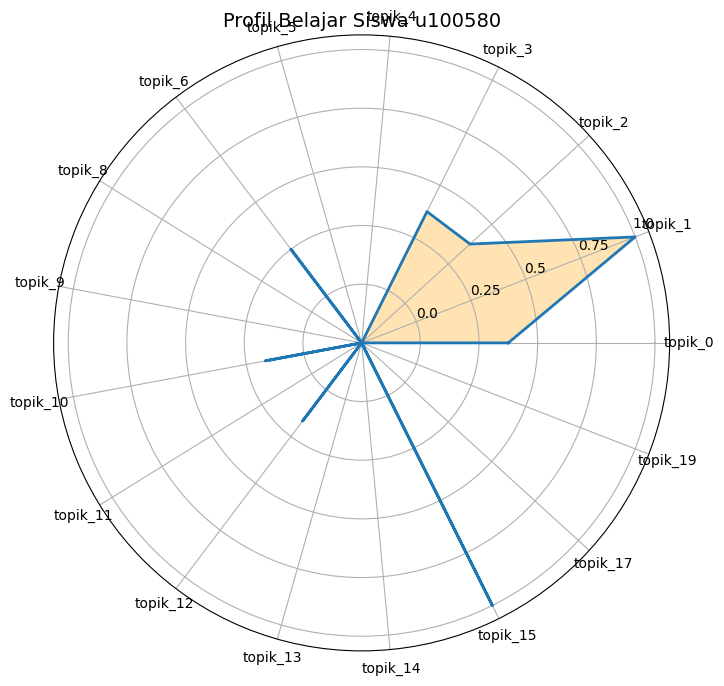

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Pilih 1 siswa
user_id = 'u100580'
row = matriks.loc[user_id].dropna()

labels = row.index.tolist()
values = row.values.tolist()
values += values[:1]  # ulang titik pertama untuk menutup lingkaran

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# Radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, values, linewidth=2, linestyle='solid')
ax.fill(angles, values, color='orange', alpha=0.3)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticklabels(['0.0', '0.25', '0.5', '0.75', '1.0'])
ax.set_title(f"Profil Belajar Siswa {user_id}", fontsize=14)
plt.show()


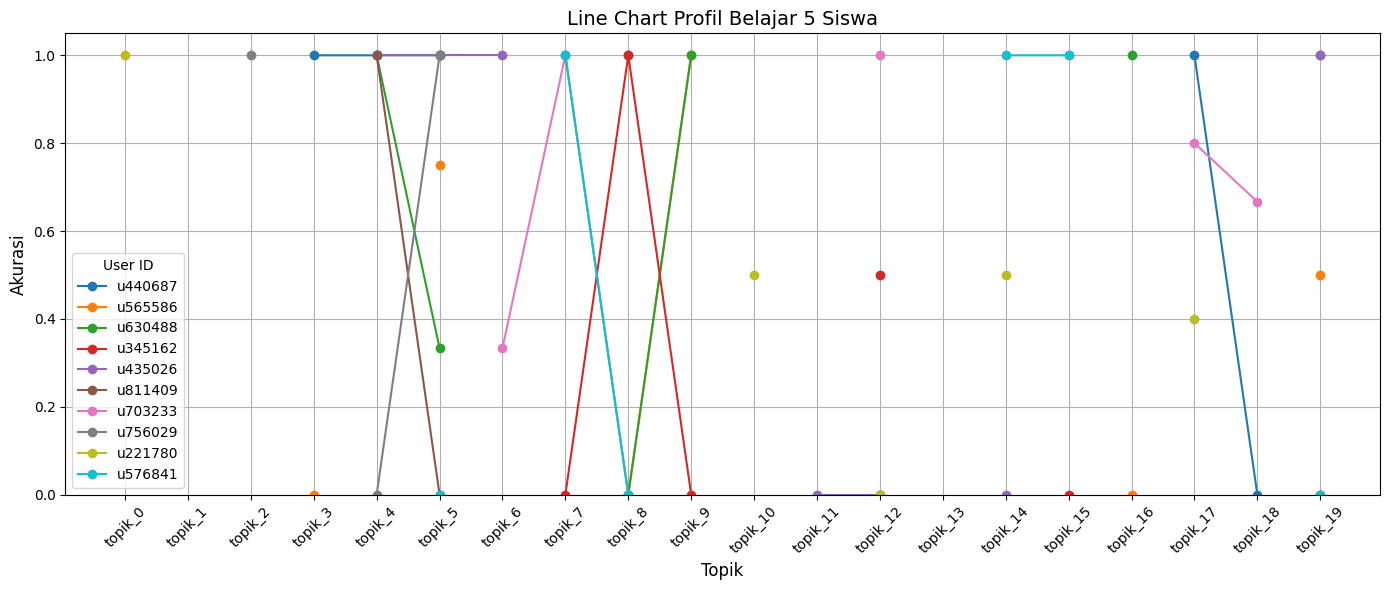

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load matriks user-topik
matriks = pd.read_csv("matriks_user_topik.csv", index_col=0)

# Pilih 5 siswa acak dengan data cukup
sample_users = matriks.dropna(thresh=5).sample(10, random_state=42)

# Plot line chart
plt.figure(figsize=(14, 6))

for user_id, row in sample_users.iterrows():
    plt.plot(row.index, row.values, marker='o', label=user_id)

# Kustomisasi
plt.title("Line Chart Profil Belajar 5 Siswa", fontsize=14)
plt.xlabel("Topik", fontsize=12)
plt.ylabel("Akurasi", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.legend(title="User ID")
plt.grid(True)
plt.tight_layout()
plt.show()


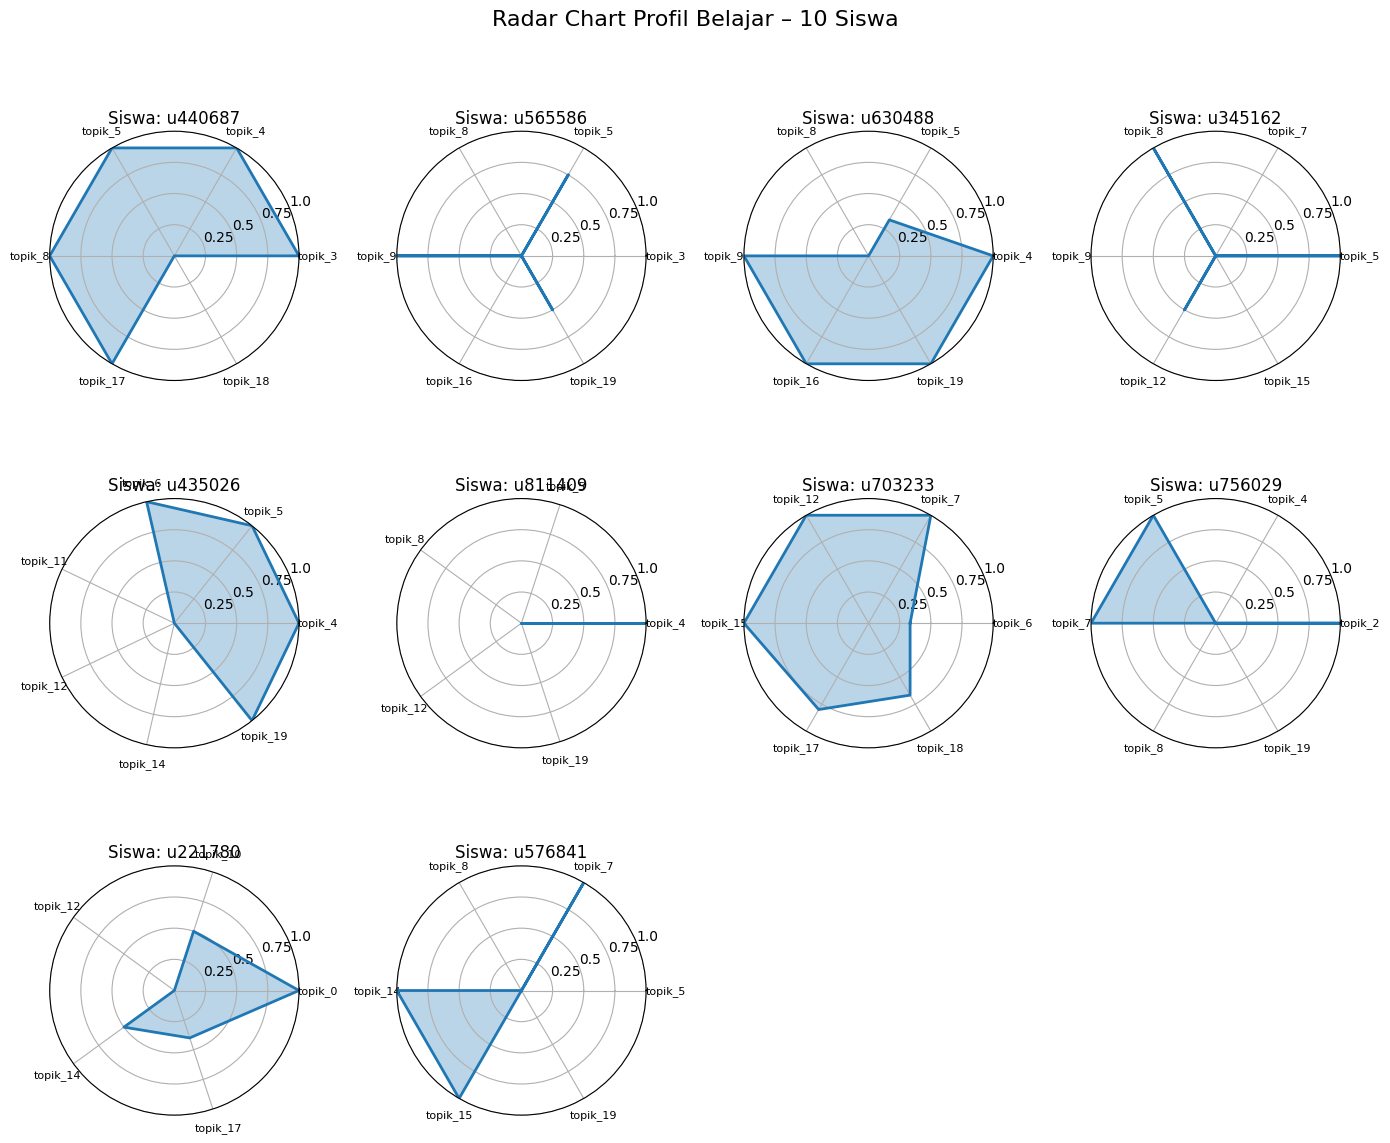

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
matriks = pd.read_csv("matriks_user_topik.csv", index_col=0)

# Ambil 10 siswa acak dengan ≥5 topik
sampel_10 = matriks.dropna(thresh=5).sample(10, random_state=42)

# Setup subplot grid: 2 kolom × 5 baris
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(14, 20), subplot_kw=dict(polar=True))
axs = axs.flatten()

# Plot radar chart untuk tiap siswa
for i, (user_id, row) in enumerate(sampel_10.iterrows()):
    scores = row.dropna().values.tolist()
    labels = row.dropna().index.tolist()

    if len(scores) < 3:
        continue  # Skip siswa yang datanya kurang

    # Persiapkan data
    scores += [scores[0]]  # untuk menutup lingkaran
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    # Radar plot di subplot
    ax = axs[i]
    ax.plot(angles, scores, linewidth=2)
    ax.fill(angles, scores, alpha=0.3)
    ax.set_title(f"Siswa: {user_id}", fontsize=12)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=8)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(['0.25', '0.5', '0.75', '1.0'])
    ax.set_ylim(0, 1)

# Bersihkan sisa subplot jika <10 siswa valid
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle("Radar Chart Profil Belajar – 10 Siswa", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


## 10. Rekomendasi Pembelajaran Adaptif

In [ ]:
import pandas as pd

# Load matriks performa
matriks = pd.read_csv("matriks_user_topik.csv", index_col=0)

# Threshold akurasi: topik dianggap lemah jika < 0.5
def rekomendasi_topik(row, threshold=0.5):
    lemah = row[row < threshold].dropna()
    return list(lemah.index)

# Buat DataFrame hasil rekomendasi
rekomendasi = matriks.apply(lambda row: rekomendasi_topik(row), axis=1)
rekomendasi_df = pd.DataFrame({
    'user_id': rekomendasi.index,
    'topik_direkomendasikan': rekomendasi.values
})

# Simpan ke file
rekomendasi_df.to_csv("rekomendasi_pembelajaran_adaptif.csv", index=False)

# Lihat contoh
rekomendasi_df.head()


,user_id,topik_direkomendasikan
0,u100580,"[topik_4, topik_5, topik_6, topik_8, topik_9, ..."
1,u101409,"[topik_4, topik_9, topik_10, topik_11, topik_1..."
2,u102852,"[topik_1, topik_5, topik_11, topik_12, topik_1..."
3,u106217,[]
4,u106643,"[topik_0, topik_11, topik_14]"


<ipython-input-28-c3eaef293102>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=topik_df.head(10), x='jumlah_siswa', y='topik', palette='Reds_r')


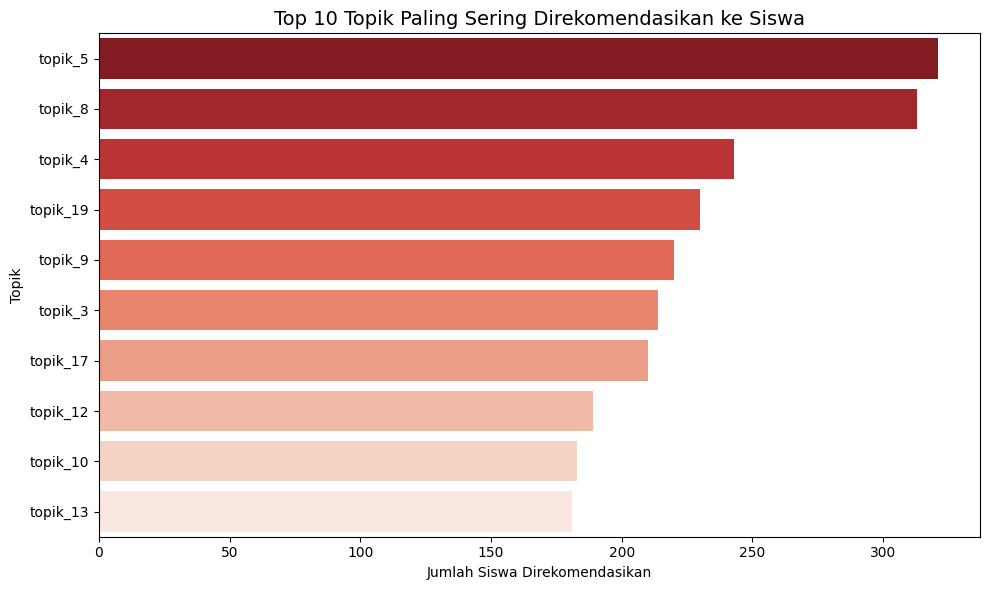

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load hasil rekomendasi
rekom_df = pd.read_csv("rekomendasi_pembelajaran_adaptif.csv")

# Ubah string list ke list Python asli
rekom_df['topik_direkomendasikan'] = rekom_df['topik_direkomendasikan'].apply(eval)

# Gabungkan semua list jadi satu list besar
all_topik = sum(rekom_df['topik_direkomendasikan'].tolist(), [])

# Hitung frekuensi topik
topik_counter = Counter(all_topik)
topik_df = pd.DataFrame(topik_counter.items(), columns=['topik', 'jumlah_siswa'])

# Urutkan topik berdasarkan jumlah siswa yang direkomendasikan
topik_df = topik_df.sort_values(by='jumlah_siswa', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=topik_df.head(10), x='jumlah_siswa', y='topik', palette='Reds_r')
plt.title("Top 10 Topik Paling Sering Direkomendasikan ke Siswa", fontsize=14)
plt.xlabel("Jumlah Siswa Direkomendasikan")
plt.ylabel("Topik")
plt.tight_layout()
plt.show()



# **VARK**

In [ ]:
import pandas as pd

# Load matriks user × topik
df = pd.read_csv("matriks_user_topik.csv", index_col=0)

# Buat mapping topik ke kategori VARK
topik_to_vark = {
    'topik_0': 'visual', 'topik_1': 'reading', 'topik_2': 'kinesthetic', 'topik_3': 'auditory',
    'topik_4': 'visual', 'topik_5': 'reading', 'topik_6': 'auditory', 'topik_7': 'kinesthetic',
    'topik_8': 'visual', 'topik_9': 'reading', 'topik_10': 'kinesthetic', 'topik_11': 'auditory',
    'topik_12': 'visual', 'topik_13': 'reading', 'topik_14': 'auditory', 'topik_15': 'kinesthetic',
    'topik_16': 'visual', 'topik_17': 'reading', 'topik_18': 'auditory', 'topik_19': 'kinesthetic'
}

# Transpose dan melt untuk long format
df_long = df.reset_index().melt(id_vars='user_id', var_name='topik', value_name='akurasi')

# Tambah kategori VARK
df_long['vark'] = df_long['topik'].map(topik_to_vark)

# Hapus yang tidak ada mapping atau NaN akurasi
df_long = df_long.dropna(subset=['vark', 'akurasi'])

# Hitung rata-rata akurasi per user_id × VARK
vark_scores = df_long.groupby(['user_id', 'vark'])['akurasi'].mean().unstack().fillna(0)

# Tentukan gaya dominan
vark_scores['vark_dominan'] = vark_scores[['visual', 'auditory', 'reading', 'kinesthetic']].idxmax(axis=1)

# Simpan hasil
vark_scores.to_csv("estimasi_gaya_belajar_vark.csv")

# Tampilkan contoh
vark_scores.head()


In [ ]:
from gensim.models import CoherenceModel

# Ambil semua topik dari model
topics = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)

# Buat daftar kata per topik
topic_words = [[word for word, prob in topic[1]] for topic in topics]

# Hitung coherence untuk masing-masing topik
coherence_model = CoherenceModel(
    topics=topic_words,
    texts=soal_text_df['tokens'],
    dictionary=dictionary,
    coherence='c_v'
)
topic_coherences = coherence_model.get_coherence_per_topic()

# Tampilkan coherence per topik
for i, c in enumerate(topic_coherences):
    print(f"Topik {i}: Coherence = {c:.4f}")


In [ ]:
import matplotlib.pyplot as plt

# Asumsikan topic_coherences sudah dihitung dari CoherenceModel sebelumnya
# Misalnya:
# topic_coherences = coherence_model.get_coherence_per_topic()

# Buat grafik bar
plt.figure(figsize=(12, 6))
plt.bar(range(len(topic_coherences)), topic_coherences, color='skyblue')
plt.xlabel('Topik')
plt.ylabel('Coherence Score (c_v)')
plt.title('Coherence Score per Topik')
plt.xticks(range(len(topic_coherences)), [f'Topik {i}' for i in range(len(topic_coherences))], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from gensim import corpora, models
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Baca file hasil pseudo-teks soal
soal_text_df = pd.read_csv("soal_pseudo_text.csv")

# Tokenisasi teks
texts = soal_text_df['clean_text'].apply(lambda x: x.split()).tolist()

# Buat dictionary dan corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Fungsi evaluasi dan visualisasi coherence score
def evaluate_coherence(dictionary, corpus, texts, start=2, limit=10, step=1):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit + 1, step):
        model = models.LdaModel(corpus=corpus,
                                id2word=dictionary,
                                num_topics=num_topics,
                                random_state=42,
                                update_every=1,
                                chunksize=100,
                                passes=10,
                                alpha='auto',
                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    # Visualisasi
    x = range(start, limit + 1, step)
    plt.figure(figsize=(20, 8))
    plt.plot(x, coherence_values, marker='o')
    plt.xlabel("Jumlah Topik")
    plt.ylabel("Coherence Score (c_v)")
    plt.title("Evaluasi Coherence Score LDA")
    plt.xticks(x)
    plt.grid(True)
    plt.show()

    return model_list, coherence_values

# Jalankan evaluasi
model_list, coherence_values = evaluate_coherence(dictionary, corpus, texts, start=2, limit=10, step=1)
